In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [2]:
m1 = np.arange(10,0,-1)
m2 = np.arange(10)
m = np.concatenate((m1,m2))
train_x_orig = np.tile(m,300)
print(train_x_orig)
print ("train_x_orig's shape: " + str(train_x_orig.shape))

[10  9  8 ...,  7  8  9]
train_x_orig's shape: (6000,)


In [3]:
step = 1
lenth = 10
w = np.array([list(train_x_orig[0:0+lenth])])
for i in range(step, len(train_x_orig)-15, step):
    w2 = np.array([list(train_x_orig[i:i+lenth])])
    w = np.concatenate((w,w2),axis=0)
print(w)
print ("w's shape: " + str(w.shape))

[[10  9  8 ...,  3  2  1]
 [ 9  8  7 ...,  2  1  0]
 [ 8  7  6 ...,  1  0  1]
 ..., 
 [ 8  7  6 ...,  1  0  1]
 [ 7  6  5 ...,  0  1  2]
 [ 6  5  4 ...,  1  2  3]]
w's shape: (5985, 10)


In [4]:
train_y_orig = []
for x in w:
    y = x[5]
    flag = 0
    if y ==10 or y == 0:
        flag = 1
    train_y_orig = np.append(train_y_orig, flag)
print(train_y_orig)
print ("train_y_orig's shape: " + str(train_y_orig.shape))

[ 0.  0.  0. ...,  0.  0.  0.]
train_y_orig's shape: (5985,)


In [5]:
c = train_y_orig.copy()
print ("c's shape: " + str(c.shape))

c's shape: (5985,)


[ 12.50213203  13.32194696   8.00068625 ...,   7.15714612  13.70496794
  12.41950585]
train_x_orig's shape: (6000,)


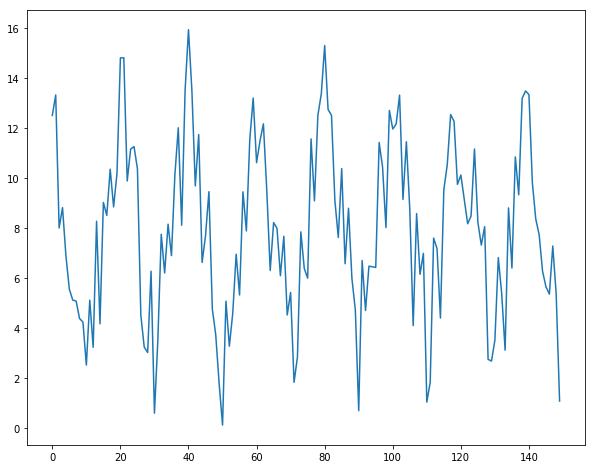

In [6]:
noisy = 6.0*np.random.rand(len(train_x_orig))
train_x_orig = train_x_orig + noisy

print(train_x_orig)
print ("train_x_orig's shape: " + str(train_x_orig.shape))

plt.plot(train_x_orig[0:150])
plt.show()

In [7]:
step = 1
lenth = 10
w = np.array([list(train_x_orig[0:0+lenth])])
for i in range(step, len(train_x_orig)-15, step):
    w2 = np.array([list(train_x_orig[i:i+lenth])])
    w = np.concatenate((w,w2),axis=0)
print(w)
print ("w's shape: " + str(w.shape))

[[ 12.50213203  13.32194696   8.00068625 ...,   5.07336436   4.38060485
    4.2329004 ]
 [ 13.32194696   8.00068625   8.81399544 ...,   4.38060485   4.2329004
    2.51516709]
 [  8.00068625   8.81399544   6.88053534 ...,   4.2329004    2.51516709
    5.111317  ]
 ..., 
 [ 10.87432307  12.55896844   6.18932813 ...,   6.35088443   4.1881147
    5.02109884]
 [ 12.55896844   6.18932813  10.62969948 ...,   4.1881147    5.02109884
    7.84146784]
 [  6.18932813  10.62969948   6.09177276 ...,   5.02109884   7.84146784
    5.79065241]]
w's shape: (5985, 10)


In [8]:
print(w.max())

15.9901492918


In [9]:
train_x = w[0:len(w)*3//4]
test_x = w[len(w)*3//4:len(w)]

train_x = train_x.T
test_x = test_x.T

# Standardize data to have feature values between 0 and 1.
train_x = train_x/train_x.max()
test_x = test_x/test_x.max()

train_y = np.array([c[0:len(c)*3//4]])
test_y = np.array([c[len(c)*3//4:len(c)]])

print ("train_x's shape: " + str(train_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (10, 4488)
train_y's shape: (1, 4488)
test_x's shape: (10, 1497)
test_y's shape: (1, 1497)


In [10]:
print(train_x)
print ("train_x's shape: " + str(train_x.shape))

[[ 0.78330417  0.83466856  0.50127217 ...,  0.41797982  0.46578846
   0.31663502]
 [ 0.83466856  0.50127217  0.55222896 ...,  0.46578846  0.31663502
   0.44076626]
 [ 0.50127217  0.55222896  0.43109063 ...,  0.31663502  0.44076626
   0.32050328]
 ..., 
 [ 0.31786478  0.27446087  0.26520665 ...,  0.19492564  0.39193419
   0.27369554]
 [ 0.27446087  0.26520665  0.15758439 ...,  0.39193419  0.27369554
   0.51553621]
 [ 0.26520665  0.15758439  0.32024265 ...,  0.27369554  0.51553621
   0.50223051]]
train_x's shape: (10, 4488)


In [11]:
### CONSTANTS ###
layers_dims = [10, 10, 7, 5, 1] #  5-layer model

In [12]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters =  update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.498790
Cost after iteration 100: 0.331432
Cost after iteration 200: 0.328435
Cost after iteration 300: 0.323851
Cost after iteration 400: 0.321573
Cost after iteration 500: 0.319798
Cost after iteration 600: 0.318061
Cost after iteration 700: 0.316304
Cost after iteration 800: 0.314469
Cost after iteration 900: 0.312466
Cost after iteration 1000: 0.310010
Cost after iteration 1100: 0.306956
Cost after iteration 1200: 0.303943
Cost after iteration 1300: 0.300954
Cost after iteration 1400: 0.297764
Cost after iteration 1500: 0.294264
Cost after iteration 1600: 0.290403
Cost after iteration 1700: 0.286139
Cost after iteration 1800: 0.281486
Cost after iteration 1900: 0.276461
Cost after iteration 2000: 0.271144
Cost after iteration 2100: 0.265539
Cost after iteration 2200: 0.259618
Cost after iteration 2300: 0.253366
Cost after iteration 2400: 0.246871
Cost after iteration 2500: 0.240226
Cost after iteration 2600: 0.233524
Cost after iteration 2700: 0.226877
Cost

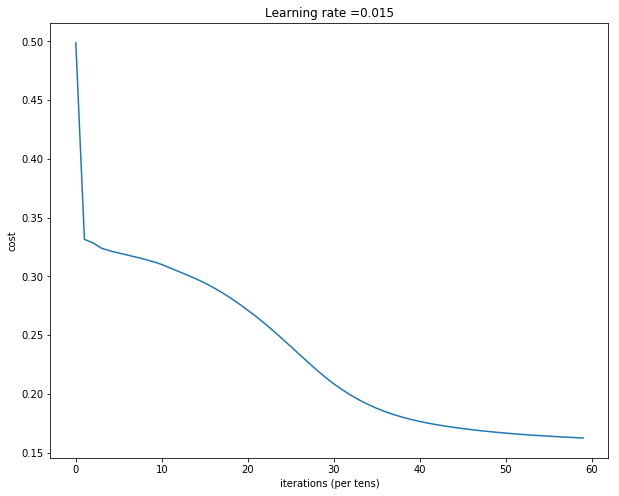

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.015, num_iterations = 6000, print_cost = True)

In [14]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.927187708751


In [15]:
print(predictions_test[:,0:140])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


(2, 10.998358215305066)
(12, 10.998358215305066)
(22, 10.998358215305066)
(32, 10.998358215305066)
(42, 10.998358215305066)
(52, 10.998358215305066)
(62, 10.998358215305066)
(72, 10.998358215305066)
(82, 10.998358215305066)
(92, 10.998358215305066)
(102, 10.998358215305066)
(112, 10.998358215305066)
(122, 10.998358215305066)
(132, 10.998358215305066)


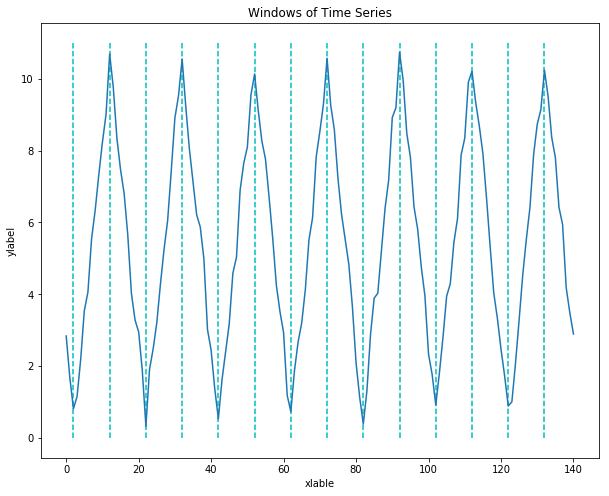

In [16]:
plot_data = train_x_orig[step*len(w)*3//4:step*len(w)*3//4+141]
plt.plot(plot_data)
p = predictions_test[:,0:140]

s = 0
for i in p[0]:
    if i == 1.0:
        x = s*step-5
        print((x, w.max()))
        plt.vlines(x, 0, 11, colors = "c", linestyles = "dashed")
    s += 1
plt.ylabel('ylabel')
plt.xlabel('xlable')
plt.title("Windows of Time Series")
plt.show()

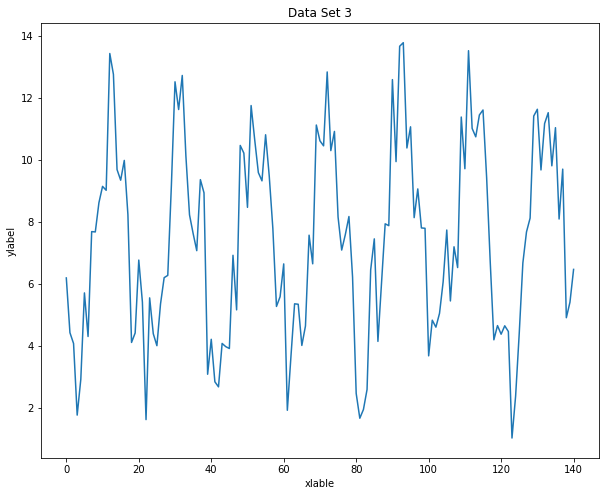

In [17]:
plt.plot(plot_data)
plt.ylabel('ylabel')
plt.xlabel('xlable')
plt.title("Data Set 3")
plt.show()

In [33]:
p[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [41]:
for i in p[0]:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
